In [1]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import datetime
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool

import tensorflow as tf
import sklearn
import sklearn.metrics

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras import backend as K
from keras import optimizers

from keras.callbacks import TensorBoard

tf.__version__

Using TensorFlow backend.


'1.5.0'

In [1]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time

Using TensorFlow backend.


In [2]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [3]:
# the data, split between train and test sets
dfAll = pd.read_pickle("PklData/df_blobs.pkl")
df_train = dfAll[(dfAll.userID != 1) | (dfAll.userID != 2)]
df_test = dfAll[(dfAll.userID == 1) | (dfAll.userID == 2)]

df_test = df_test.reset_index()
df_train = df_train.reset_index()
#Create InputMethod Column and fill it with Knuckel / Finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df_train['InputMethod'] = df_train.apply(f, axis=1)
df_test['InputMethod'] = df_test.apply(f, axis=1)
df_train2 = df_train[['Blobs', 'InputMethod']].copy()
df_test2 = df_test[['Blobs', 'InputMethod']].copy()

In [4]:
x_train = np.vstack(df_train2.Blobs)
x_test = np.vstack(df_test2.Blobs)
y_train = df_train2.InputMethod.values
y_test = df_test2.InputMethod.values

x_train = x_train.reshape(-1, 27, 15, 1)
x_test = x_test.reshape(-1, 27, 15, 1)

In [5]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y_train_one_hot = tf.keras.utils.to_categorical(df_train2.InputMethod, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(df_test2.InputMethod, num_classes)

Text(0.5,1,'Label for image 1 is: 0')

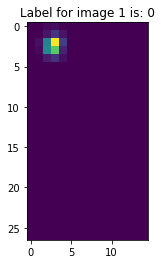

In [6]:
i = 1
plt.imshow(x_train[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y_train[i]))

In [7]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [15]:
########## HYPER PARAMETERS
batch_size = 200
epochs = 5000
#optimizer = tf.keras.optimizers.Adam()\n",
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)

########## HYPER PARAMETERS
########## MODEL ARCHITECTURE
model = tf.keras.Sequential()


model.add(tf.keras.layers.Conv2D(84, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1)))
model.add(tf.keras.layers.Conv2D(84, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format='channels_last'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Conv2D(42, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(42, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format='channels_last'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(400, activation=('relu'), use_bias=True))
model.add(tf.keras.layers.Dense(100, activation=('relu'), use_bias=True))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE

####TENSORBOARD
config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
#### END TENSORBOARD


# Print summary
model.summary()
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_" + readable_timestamp

# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot))
                    #callbacks=[LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0, write_graph=True, write_images=True, update_freq = 'epoch')])
                    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 27, 15, 84)        840       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 27, 15, 84)        63588     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 7, 84)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 13, 7, 84)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 7, 42)         31794     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 13, 7, 42)         15918     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 3, 42)          0         
__________

KeyboardInterrupt: 

In [ ]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()

In [ ]:
# save model
model.save("2312.h5")